In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# Load feature-engineered dataset
df = pd.read_csv('C:/Users/Saisa/Downloads/Walmart_Sales/data/processed/feature_engineered_sales.csv', parse_dates=['date'])

# Sort by store/date to preserve sequence
df = df.sort_values(by=['store', 'date'])

# Filter for store 1 (or loop later)
store_df = df[df['store'] == 1].copy()


In [4]:
# Train-Test Split

# Define features and target
target = 'weekly_sales'
exclude = ['date', 'store', 'dept', target]
features = [col for col in df.columns if col not in exclude]

# Time-based split
split_date = df['date'].quantile(0.8)
train = df[df['date'] < split_date]
test = df[df['date'] >= split_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [5]:
# Define Models

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
}


In [6]:
# Training 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Target variable
y = df['weekly_sales']

# Drop columns you don’t want (but keep 'store_name' and 'holiday_name')
X = df.drop(columns=['weekly_sales', 'date'])  # 'dept' already removed

# Separate categorical and numeric features
X_cat = X[['store_name', 'holiday_name']]
X_num = X.drop(columns=['store_name', 'holiday_name'])

# One-hot encode categorical columns
ohe = OneHotEncoder(sparse_output=False, drop='first')  # ✅ Changed this
X_cat_encoded = pd.DataFrame(ohe.fit_transform(X_cat), columns=ohe.get_feature_names_out(X_cat.columns))

# Combine numeric and encoded categorical features
X_final = pd.concat([X_num.reset_index(drop=True), X_cat_encoded.reset_index(drop=True)], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


# Model Diagonstics


In [7]:
# Evaluate

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
import os
import pandas as pd

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 4)
    })

    if name == 'XGBoost':
        joblib.dump(model, 'C:/Users/Saisa/Downloads/Walmart_Sales/models/xgboost_model.pkl')



# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('C:/Users/Saisa/Downloads/Walmart_Sales/outputs/metrics/model_comparison.csv', index=False)
results_df


,Model,MAE,RMSE,R² Score
0,Linear Regression,31485.60,44491.43,0.9940
1,Random Forest,24466.05,39601.32,0.9952
2,XGBoost,23876.27,36486.79,0.9959


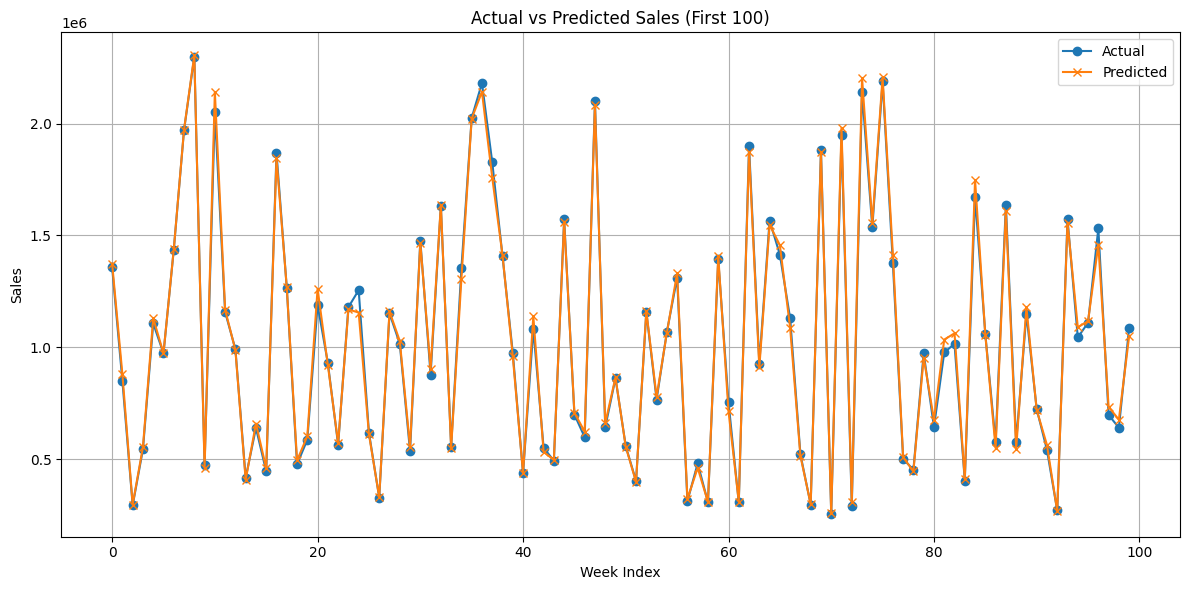

In [8]:
# Plot Actual vs Predicted

import matplotlib.pyplot as plt

best_model = joblib.load('C:/Users/Saisa/Downloads/Walmart_Sales/models/xgboost_model.pkl')
y_pred = best_model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("Actual vs Predicted Sales (First 100)")
plt.xlabel("Week Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/Saisa/Downloads/Walmart_Sales/outputs/plots/actual_vs_predicted.png')
plt.show()


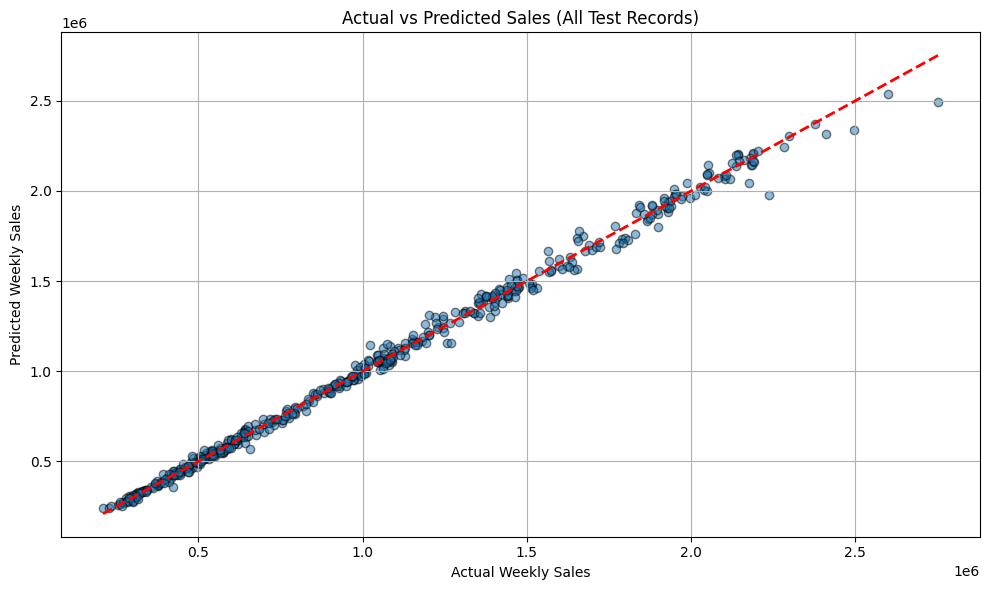

In [ ]:
# Scatter Plot: Actual vs Predicted Sales (All records)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Reference line
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Actual vs Predicted Sales (All Test Records)')
plt.grid(True)
plt.tight_layout()
plt.show()


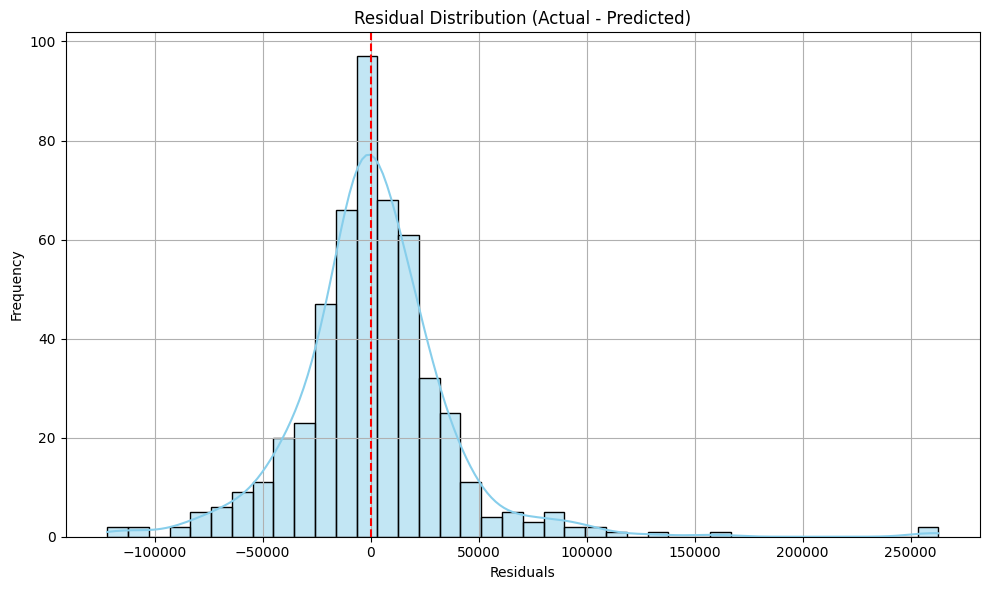

In [ ]:
# Residual Plot: Actual - Predicted Errors

import seaborn as sns
import numpy as np

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=40, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residual Distribution (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


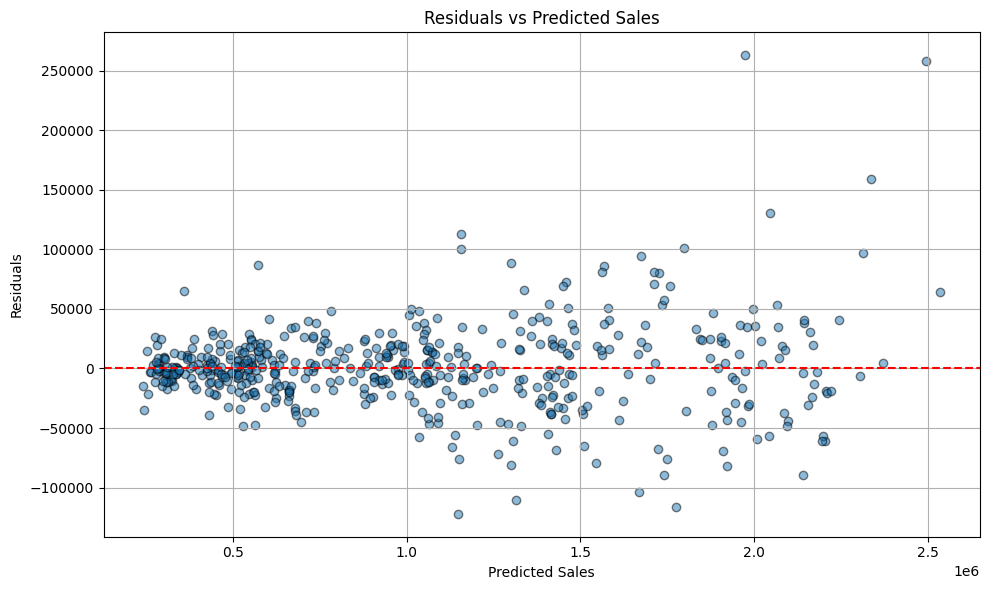

In [ ]:
# Residuals vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
from prophet import Prophet
import os
import pickle
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("C:/Users/Saisa/Downloads/Walmart_Sales/data/processed/feature_engineered_sales.csv", parse_dates=['date'])

# Create folders if they don’t exist
os.makedirs("C:/Users/Saisa/Downloads/Walmart_Sales/models", exist_ok=True)
os.makedirs("C:/Users/Saisa/Downloads/Walmart_Sales/outputs/plots", exist_ok=True)

# Loop through all stores
store_ids = df['store'].unique()

for store_id in store_ids:
    try:
        # Filter data for the store
        store_df = df[df['store'] == store_id][['date', 'weekly_sales']].rename(columns={
            'date': 'ds',
            'weekly_sales': 'y'
        })

        # Prophet model
        model = Prophet()
        model.fit(store_df)

        # Save model
        model_path = f"C:/Users/Saisa/Downloads/Walmart_Sales/models/prophet_store_{store_id}.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

        # Forecast
        future = model.make_future_dataframe(periods=12, freq='W')
        forecast = model.predict(future)

        # Plot and save
        fig = model.plot(forecast)
        plot_path = f"C:/Users/Saisa/Downloads/Walmart_Sales/outputs/plots/prophet_store_{store_id}.png"
        fig.savefig(plot_path)
        plt.close(fig)  # Close to free memory

        print(f"✅ Store {store_id} - Model and plot saved.")

    except Exception as e:
        print(f"❌ Store {store_id} - Error: {e}")


22:04:15 - cmdstanpy - INFO - Chain [1] start processing
22:04:16 - cmdstanpy - INFO - Chain [1] done processing
22:04:16 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 1 - Model and plot saved.


22:04:16 - cmdstanpy - INFO - Chain [1] done processing
22:04:17 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 2 - Model and plot saved.


22:04:17 - cmdstanpy - INFO - Chain [1] done processing
22:04:17 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 3 - Model and plot saved.


22:04:18 - cmdstanpy - INFO - Chain [1] done processing
22:04:18 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 4 - Model and plot saved.


22:04:18 - cmdstanpy - INFO - Chain [1] done processing
22:04:18 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 5 - Model and plot saved.


22:04:19 - cmdstanpy - INFO - Chain [1] done processing
22:04:19 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 6 - Model and plot saved.


22:04:19 - cmdstanpy - INFO - Chain [1] done processing
22:04:19 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 7 - Model and plot saved.


22:04:20 - cmdstanpy - INFO - Chain [1] done processing
22:04:20 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 8 - Model and plot saved.


22:04:20 - cmdstanpy - INFO - Chain [1] done processing
22:04:21 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 9 - Model and plot saved.


22:04:21 - cmdstanpy - INFO - Chain [1] done processing
22:04:21 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 10 - Model and plot saved.


22:04:22 - cmdstanpy - INFO - Chain [1] done processing
22:04:22 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 11 - Model and plot saved.


22:04:22 - cmdstanpy - INFO - Chain [1] done processing
22:04:23 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 12 - Model and plot saved.


22:04:23 - cmdstanpy - INFO - Chain [1] done processing
22:04:23 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 13 - Model and plot saved.


22:04:23 - cmdstanpy - INFO - Chain [1] done processing
22:04:24 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 14 - Model and plot saved.


22:04:24 - cmdstanpy - INFO - Chain [1] done processing
22:04:24 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 15 - Model and plot saved.


22:04:25 - cmdstanpy - INFO - Chain [1] done processing
22:04:25 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 16 - Model and plot saved.


22:04:25 - cmdstanpy - INFO - Chain [1] done processing
22:04:26 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 17 - Model and plot saved.


22:04:26 - cmdstanpy - INFO - Chain [1] done processing
22:04:26 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 18 - Model and plot saved.


22:04:26 - cmdstanpy - INFO - Chain [1] done processing
22:04:27 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 19 - Model and plot saved.


22:04:27 - cmdstanpy - INFO - Chain [1] done processing
22:04:27 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 20 - Model and plot saved.


22:04:28 - cmdstanpy - INFO - Chain [1] done processing
22:04:28 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 21 - Model and plot saved.


22:04:28 - cmdstanpy - INFO - Chain [1] done processing
22:04:29 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 22 - Model and plot saved.


22:04:29 - cmdstanpy - INFO - Chain [1] done processing
22:04:29 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 23 - Model and plot saved.


22:04:30 - cmdstanpy - INFO - Chain [1] done processing
22:04:30 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 24 - Model and plot saved.


22:04:30 - cmdstanpy - INFO - Chain [1] done processing
22:04:30 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 25 - Model and plot saved.


22:04:31 - cmdstanpy - INFO - Chain [1] done processing
22:04:31 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 26 - Model and plot saved.


22:04:31 - cmdstanpy - INFO - Chain [1] done processing
22:04:32 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 27 - Model and plot saved.


22:04:32 - cmdstanpy - INFO - Chain [1] done processing
22:04:32 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 28 - Model and plot saved.


22:04:33 - cmdstanpy - INFO - Chain [1] done processing
22:04:33 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 29 - Model and plot saved.


22:04:33 - cmdstanpy - INFO - Chain [1] done processing
22:04:34 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 30 - Model and plot saved.


22:04:34 - cmdstanpy - INFO - Chain [1] done processing
22:04:34 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 31 - Model and plot saved.


22:04:35 - cmdstanpy - INFO - Chain [1] done processing
22:04:35 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 32 - Model and plot saved.


22:04:36 - cmdstanpy - INFO - Chain [1] done processing
22:04:36 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 33 - Model and plot saved.


22:04:36 - cmdstanpy - INFO - Chain [1] done processing
22:04:37 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 34 - Model and plot saved.


22:04:37 - cmdstanpy - INFO - Chain [1] done processing
22:04:37 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 35 - Model and plot saved.


22:04:38 - cmdstanpy - INFO - Chain [1] done processing
22:04:38 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 36 - Model and plot saved.


22:04:38 - cmdstanpy - INFO - Chain [1] done processing
22:04:39 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 37 - Model and plot saved.


22:04:39 - cmdstanpy - INFO - Chain [1] done processing
22:04:39 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 38 - Model and plot saved.


22:04:39 - cmdstanpy - INFO - Chain [1] done processing
22:04:40 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 39 - Model and plot saved.


22:04:40 - cmdstanpy - INFO - Chain [1] done processing
22:04:40 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 40 - Model and plot saved.


22:04:41 - cmdstanpy - INFO - Chain [1] done processing
22:04:41 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 41 - Model and plot saved.


22:04:41 - cmdstanpy - INFO - Chain [1] done processing
22:04:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 42 - Model and plot saved.


22:04:42 - cmdstanpy - INFO - Chain [1] done processing
22:04:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 43 - Model and plot saved.


22:04:43 - cmdstanpy - INFO - Chain [1] done processing
22:04:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Store 44 - Model and plot saved.


22:04:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 45 - Model and plot saved.
